<center><h1>UNet</h1></center>

![unet](https://miro.medium.com/max/609/1*TXfEPqTbFBPCbXYh2bstlA.png "unet")
The u-net is convolutional network architecture for fast and precise segmentation of images

**Here we are using UNet for predicting the retinal vessel segments of the kaggle dataset, which will be trained on DRIVE dataset which as the manually annotated segmentations** 

In [ ]:
# !pip install -q torch torchvision albumentations

In [1]:
# Import Requried Libaries
import os
import cv2
import imageio
import torch
import torchvision
import albumentations as A
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch import optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from scipy.signal import find_peaks
from glob import glob
import warnings

warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

torch.__version__

'1.9.0+cu102'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

class DRIVEDataset(Dataset):
    def __init__(self, root, augmentation=True):
      self.root = root
      self.images = list(sorted(os.listdir(os.path.join(self.root, "images"))))
      self.masks = list(sorted(os.listdir(os.path.join(self.root, "1st_manual"))))
      self.augmentation = augmentation
      self.aug = A.Compose({A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)})
        
    def __len__(self):
        return len(self.images)

    @classmethod
    def smooth(cls, x, window_len=11, window='hanning'):
    #Ref: https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html

      if x.ndim != 1:
          raise ValueError

      if x.size < window_len:
          raise ValueError


      if window_len<3:
          return x


      if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
          raise ValueError


      s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
      #print(len(s))
      if window == 'flat': #moving average
          w=np.ones(window_len,'d')
      else:
          w=eval('np.'+window+'(window_len)')

      y=np.convolve(w/w.sum(),s,mode='valid')
      return y

    @classmethod
    def sub_bg(cls, img):
      # Histogram
      hist = cv2.calcHist([img], [0], None, [256], [0, 256])

      # Smooth Histogram
      hist_smooth = cls.smooth(hist.ravel(), 5)

      # Find peaks
      peaks, _ = find_peaks(hist_smooth, distance=10)
      
      threshold = np.std(img[peaks])
      
      binary_mask = (img > threshold)
      
      binary_mask = binary_mask.astype("uint8")
      
      binary_mask[binary_mask == 1] = 255
      
      return binary_mask

    @classmethod
    def preprocessing(cls, image_path, mask_path):
      image = cv2.imread(f"{image_path}")
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      R, G, B = cv2.split(image)

      enh_img = clahe.apply(G)

      mask = imageio.mimread(f"{mask_path}")[0]
      mask = np.array(mask)

      bin_mask = cls.sub_bg(G)

      final_image = cv2.subtract(bin_mask, enh_img)

      image = cv2.resize(final_image, (480, 480), cv2.INTER_AREA)
      mask = cv2.resize(mask, (480, 480), cv2.INTER_AREA)

      image = image / 255.0
      image = image.astype(np.float32)

      mask = mask / 255.0
      mask = mask.astype(np.float32)

      return image, mask

    def __getitem__(self, idx):
      image_path = os.path.join(self.root, "images", self.images[idx])
      mask_path = os.path.join(self.root, "1st_manual", self.masks[idx])

      image, mask = self.preprocessing(image_path, mask_path)

      if self.augmentation:
        transformed = self.aug(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask']

      image_patches = extract_patches_2d(image, (48, 48))
      mask_patches = extract_patches_2d(mask, (48, 48))

      random_patche = np.random.randint(image_patches.shape[0])

      image = image_patches[random_patche]
      mask = mask_patches[random_patche]

      image = torch.from_numpy(image)
      mask = torch.from_numpy(mask)

      image.unsqueeze_(0)
      mask.unsqueeze_(0)

      return {'image': image,
              'mask': mask}

In [33]:
class DRIVEDataset(Dataset):
  def __init__(self, path, image_label, mask_label):
    self.root = path
    self.image_label = image_label
    self.mask_label = mask_label
    self.images = list(sorted(glob(self.root+self.image_label)))
    self.masks = list(sorted(glob(self.root+self.mask_label)))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = torchvision.io.read_image(self.images[idx], torchvision.io.ImageReadMode.GRAY)
    mask = torchvision.io.read_image(self.masks[idx], torchvision.io.ImageReadMode.GRAY)

    image = image / 255.
    mask = mask / 255.

    image = torch.tensor(image, dtype=torch.float32)
    mask = torch.tensor(mask, dtype=torch.float32)

    return {'image': image,
            'mask': mask}

In [ ]:
ds = DRIVEDataset("data/DRIVE/training", False)

In [40]:
ds = DRIVEDataset("data/patches/", "*_*_img.jpg", "*_*_vessel.jpg")

In [13]:
train_idx, test_idx = train_test_split([*range(len(ds))], test_size=0.3)
train_idx[:5]

[12957, 4344, 19181, 15258, 4738]

In [41]:
train_loader = DataLoader(ds, 3, False, SubsetRandomSampler(train_idx))
test_loader = DataLoader(ds, 3, False, SubsetRandomSampler(test_idx))

In [42]:
for b in train_loader:
  break

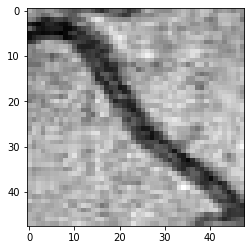

In [44]:
plt.imshow(b['image'][2].squeeze().numpy(), cmap="binary_r");

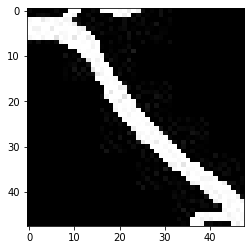

In [45]:
plt.imshow(b['mask'][2].squeeze().numpy(), cmap="binary_r");

In [19]:
class BaseConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding,
                 stride):
        super(BaseConv, self).__init__()

        self.act = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding,
                               stride)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size,
                               padding, stride)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return x


class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding,
                 stride):
        super(DownConv, self).__init__()

        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv_block = BaseConv(in_channels, out_channels, kernel_size,
                                   padding, stride)

    def forward(self, x):
        x = self.pool1(x)
        x = self.conv_block(x)
        return x


class UpConv(nn.Module):
    def __init__(self, in_channels, in_channels_skip, out_channels,
                 kernel_size, padding, stride):
        super(UpConv, self).__init__()

        self.conv_trans1 = nn.ConvTranspose2d(
            in_channels, in_channels, kernel_size=2, padding=0, stride=2)
        self.conv_block = BaseConv(
            in_channels=in_channels + in_channels_skip,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding,
            stride=stride)

    def forward(self, x, x_skip):
        x = self.conv_trans1(x)
        x = torch.cat((x, x_skip), dim=1)
        x = self.conv_block(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, n_class, kernel_size,
                 padding, stride):
        super(UNet, self).__init__()

        self.init_conv = BaseConv(in_channels, out_channels, kernel_size,
                                  padding, stride)

        self.down1 = DownConv(out_channels, 2 * out_channels, kernel_size,
                              padding, stride)

        self.down2 = DownConv(2 * out_channels, 4 * out_channels, kernel_size,
                              padding, stride)

        self.down3 = DownConv(4 * out_channels, 8 * out_channels, kernel_size,
                              padding, stride)

        self.up3 = UpConv(8 * out_channels, 4 * out_channels, 4 * out_channels,
                          kernel_size, padding, stride)

        self.up2 = UpConv(4 * out_channels, 2 * out_channels, 2 * out_channels,
                          kernel_size, padding, stride)

        self.up1 = UpConv(2 * out_channels, out_channels, out_channels,
                          kernel_size, padding, stride)

        self.out = nn.Conv2d(out_channels, n_class, kernel_size, padding, stride)

    def forward(self, x):
        # Encoder
        x = self.init_conv(x)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        # Decoder
        x_up = self.up3(x3, x2)
        x_up = self.up2(x_up, x1)
        x_up = self.up1(x_up, x)
        x_out = self.out(x_up)
        return x_out

In [20]:
torch.cuda.empty_cache()

In [21]:
def train(model, data_loader, optimzer, criterion, device):
  epoch_loss = 0.0

  model.train()
  for batch in data_loader:
    img = batch['image']
    mask = batch['mask']
    img = img.to(device, dtype=torch.float32)
    mask = mask.to(device, dtype=torch.float32)

    optimizer.zero_grad()
    pred = model(img)
    loss = criterion(pred, mask)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()

  epoch_loss = epoch_loss/len(data_loader)
  return epoch_loss

In [22]:
def evaluate(model, data_loader, criterion, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for batch in data_loader:
          img = batch['image']
          mask = batch['mask']
          img = img.to(device, dtype=torch.float32)
          mask = mask.to(device, dtype=torch.float32)
          pred = model(img)
          loss = criterion(pred, mask)
          epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(data_loader)
    return epoch_loss

In [23]:
model = UNet(in_channels=1,
             out_channels=64,
             n_class=1,
             kernel_size=3,
             padding=1,
             stride=1)

In [24]:
model = model.to(device=device)

In [25]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [26]:
# criterion = nn.BCEWithLogitsLoss()
criterion = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

In [29]:
checkpoint_path = "UNet_Patch.pth"

In [46]:
best_valid_loss = float("inf")
for epoch in range(100):
  train_loss = train(model, train_loader, optimizer, criterion, device)
  test_loss = evaluate(model, test_loader, criterion, device)

  """ Saving the model """
  if test_loss < best_valid_loss:
      data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {test_loss:2.4f}"
      print(data_str)

      best_valid_loss = test_loss
      torch.save(model.state_dict(), checkpoint_path)

  print(f"Epoch: {epoch + 1} TrainLoss: {train_loss: .3f} TestLoss: {test_loss: .3f}")

Valid loss improved from inf to 0.5835
Epoch: 1 TrainLoss:  0.731 TestLoss:  0.584
Valid loss improved from 0.5835 to 0.5603
Epoch: 2 TrainLoss:  0.576 TestLoss:  0.560
Valid loss improved from 0.5603 to 0.5286
Epoch: 3 TrainLoss:  0.541 TestLoss:  0.529
Valid loss improved from 0.5286 to 0.4952
Epoch: 4 TrainLoss:  0.513 TestLoss:  0.495
Valid loss improved from 0.4952 to 0.4715
Epoch: 5 TrainLoss:  0.490 TestLoss:  0.471
Valid loss improved from 0.4715 to 0.4715
Epoch: 6 TrainLoss:  0.475 TestLoss:  0.471
Valid loss improved from 0.4715 to 0.4560
Epoch: 7 TrainLoss:  0.462 TestLoss:  0.456
Valid loss improved from 0.4560 to 0.4426
Epoch: 8 TrainLoss:  0.450 TestLoss:  0.443
Valid loss improved from 0.4426 to 0.4295
Epoch: 9 TrainLoss:  0.439 TestLoss:  0.429
Valid loss improved from 0.4295 to 0.4254
Epoch: 10 TrainLoss:  0.429 TestLoss:  0.425
Epoch: 11 TrainLoss:  0.420 TestLoss:  0.425
Valid loss improved from 0.4254 to 0.4159
Epoch: 12 TrainLoss:  0.409 TestLoss:  0.416
Valid loss

In [60]:
with torch.no_grad():
  img = b['image'][2].to(device=device, dtype=torch.float32).unsqueeze(1)
  pred_y = model(img)
  pred_y = torch.sigmoid(pred_y)

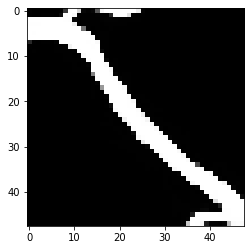

In [61]:
plt.imshow(pred_y.detach().to("cpu").squeeze().numpy(), cmap="binary_r")

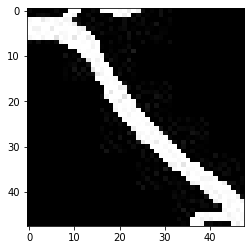

In [62]:
plt.imshow(b['mask'][2].squeeze().numpy(), cmap="binary_r");

In [112]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score

In [96]:
test_loader = DataLoader(ds, 1, False, SubsetRandomSampler(test_idx))

In [114]:
acc = []
f1 = []
roc = []

with torch.no_grad():
  for batch in test_loader:
    img = batch['image']
    mask = batch['mask']

    img = img.to(device, dtype=torch.float32)
    mask = mask.to(device, dtype=torch.float32)

    pred_y = model(img)
    pred_y = torch.sigmoid(pred_y)

    pred = pred_y.detach().to("cpu").squeeze().numpy()
    pred = pred > 0.5
    pred = pred.reshape(-1)

    true = mask.detach().to("cpu").squeeze().numpy()
    true = true > 0.5
    true = true.reshape(-1)

    acc.append(accuracy_score(true, pred))
    f1.append(f1_score(true, pred))
    roc.append(roc_auc_score(true, pred))

print(f"Accuracy: {np.mean(acc)}")
print(f"F1 Score: {np.mean(f1)}")
print(f"ROC AUC Score: {np.mean(roc)}")

Accuracy: 0.962843532986111
F1 Score: 0.865359376621077
ROC AUC Score: 0.9198056534314049
